In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# data load

In [4]:
df = pd.read_csv('./KAG_energydata_complete.csv')
df.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


10분 마다 하나의 데이터 포인트가 있다.

In [5]:
df.shape

(19735, 29)

* Date : year-month-day hour:minute:second

* Appliances : energy use in Wh

* Lights : energy use of light fixtures in the house in Wh

* T1 : Temperature in kitchen(Celsius)
* RH_1 : Humidity in kitchen(%)
* T2 : emperature in living room
* RH_2 : Humidity in living room
* T3 : Temperature in laundry room
* RH_3 : Humidity in laundry room
* T4 : Temperature in office room
* RH_4 : Humidity in office room
* T5 : Temperature in bathroom
* RH_5 : Humidity in bathroom
* T6 : Temperature outside the building
* RH_6 : Humidity outside the building
* T7 : Temperature in ironing room
* RH_7 : Humidity in ironing room
* T8 : Temperature in teenager room
* RH_8 : Humidity in teenager room
* T9 : Temperature in parents room
* RH_9 : Humidity in parents room

* T_out : Temperature outside (from Chievres weather station)
* Press_mm_hg : Pressure (from Chievres weather station)
* RH_out : Humidity outside (from Chievres weather station)
* Windspeed : (from Chievres weather station) (m/s)
* Visibility : (from Chievres weather station) (km)
* Tdewpoint : (from Chievres weather station) (Â°C)
* Rv1 : Random variable 1, nondimensional
* Rv2 : Random variable 2, nondimensional


# EDA

In [6]:
from sklearn.model_selection import train_test_split

# 75% of the data is usedfor the training of the models and the rest is used for testing
train, test = train_test_split(df,test_size=0.25,random_state=40)

In [7]:
# Divide the columns based on type for clear column management

col_time=["date"]

col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg",
                "Windspeed","Visibility"]
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [8]:
# Seperate dependent and independent variables
feature_vars = train[ col_time + col_temp + col_hum + col_weather + col_light + col_randoms ]
target_vars = train[col_target]

In [9]:
# Check the distribution of values in lights column
feature_vars.lights.value_counts()

0     11438
10     1649
20     1230
30      414
40       64
50        5
60        1
Name: lights, dtype: int64

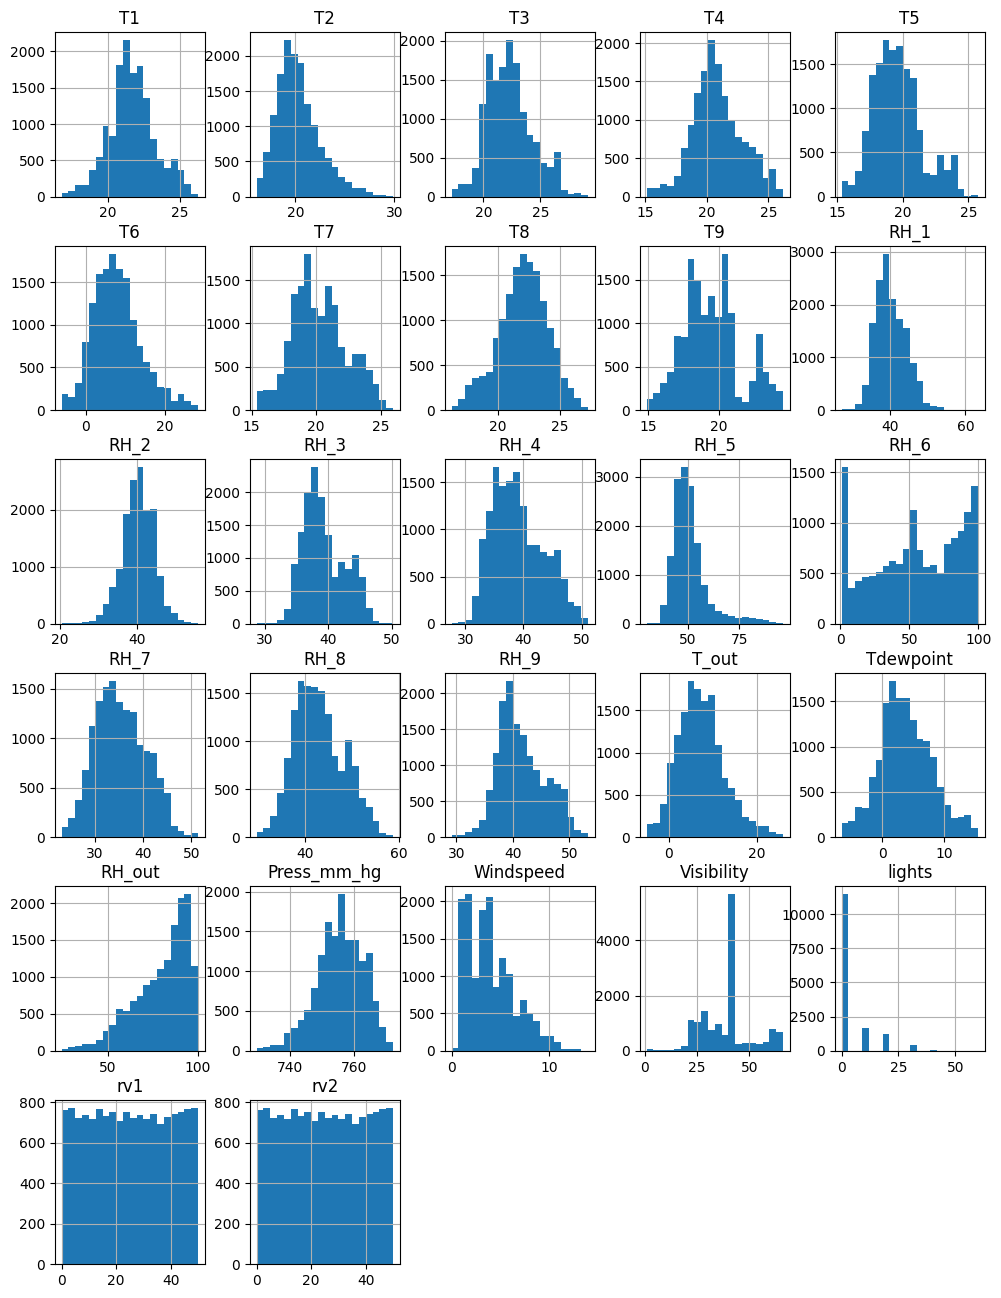

In [10]:
# Histogram of all the features to understand the distribution
feature_vars.hist(bins = 20 , figsize= (12,16)) ;

대부분은 괜찮아보이는데, RH_6, RH_out, Visibility, Windspeed 변수는 불균형한 분포를 보이고 있다. 따라서 스케일링 과정이 필요하다.

<ipython-input-11-b1b70567b451>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


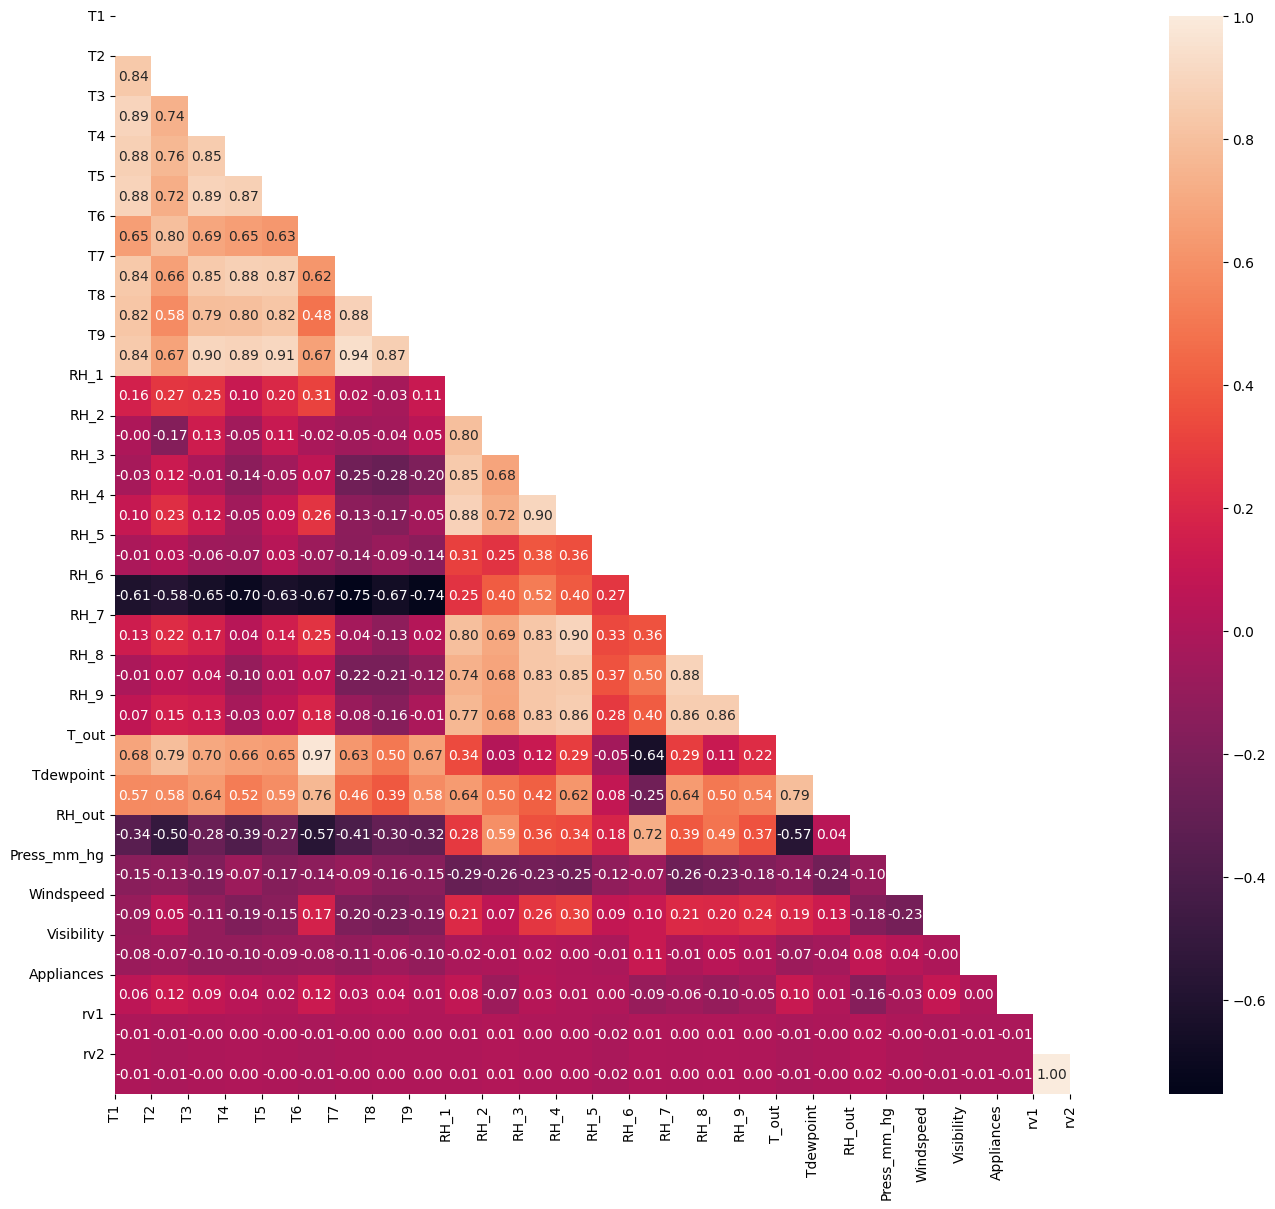

In [11]:
# Use the weather , temperature , applainces and random column to see the correlation
train_corr = train[col_temp + col_hum + col_weather +col_target+col_randoms]
corr = train_corr.corr()
# Mask the repeated values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 14))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask,)
    #Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
plt.show()

상관관계 높은 상위 3개
* Rv1 & Rv2
* T6 & T_out
* T7 & T9

date 변수는 string으로 datetime 혹은 pandas timestamp 형식으로 변환해야함.

In [12]:
df['date'] = pd.to_datetime(df['date'])
print(df['date'][0], list(df['date'])[-1])

2016-01-11 17:00:00 2016-05-27 18:00:00


데이터 세트가 거의 5달의 데이터를 가지고 있는데, 한 달 정도의 데이터만 고려하자.

In [13]:
data = df[(df['date'] > '2016-02-01 00:00:00') & (df['date'] < '2016-02-28 23:59:59')]
data = data.reset_index(drop=True)

In [14]:
# Number of rows in filtered dataframe
len(data)

4031

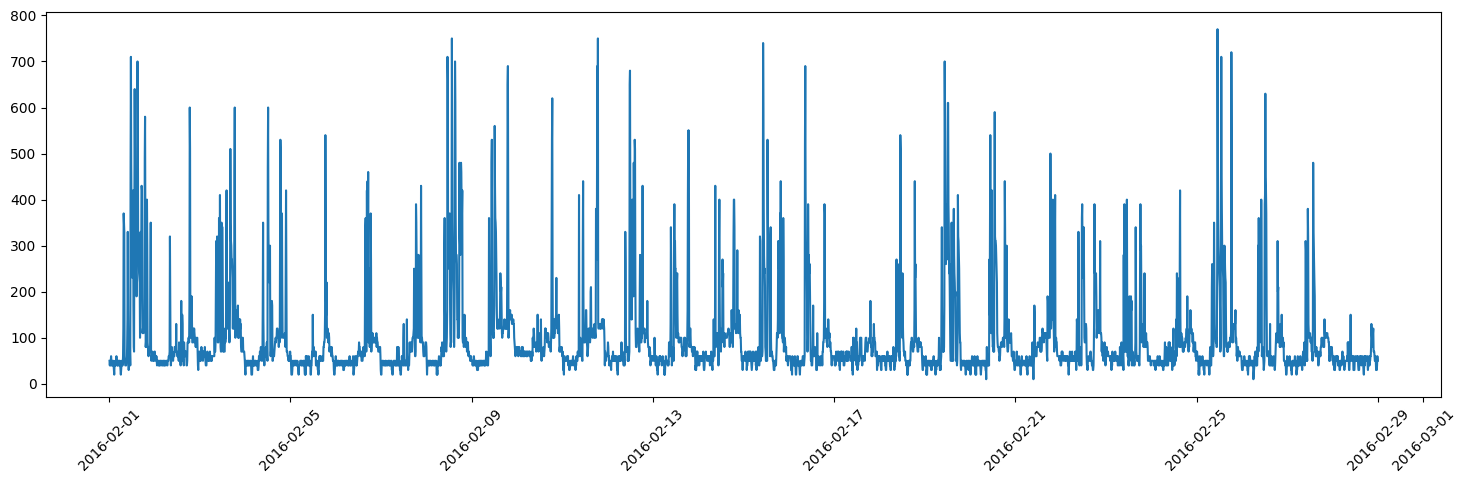

In [15]:
data = data[['date','Appliances', 'T1', 'RH_1']]

plt.rcParams["figure.figsize"] = (18,5)
plt.plot(data['date'], data['Appliances'])
plt.xticks(rotation=45)
plt.show()

데이터 변동이 너무 많다. 1시간마다 모든 데이터 포인트의 평균값을 취하여 데이터를 다시 샘플링해서 플롯을 더 부드럽게 만들수 있다.

In [16]:
# To resample the data we need to make timestamp column as the index of the dataframe
data = data.set_index('date')

In [17]:
# Resampling
data = data.resample("60T").mean()
print(f"Length after resampling: {len(data)}")
data.head()

Length after resampling: 672


,Appliances,T1,RH_1
date,,,
2016-02-01 00:00:00,46.000000,22.121667,46.613167
2016-02-01 01:00:00,46.666667,21.904444,47.050000
2016-02-01 02:00:00,38.333333,21.718889,46.966667
2016-02-01 03:00:00,48.333333,21.562500,47.011528
2016-02-01 04:00:00,45.000000,21.390556,47.122778


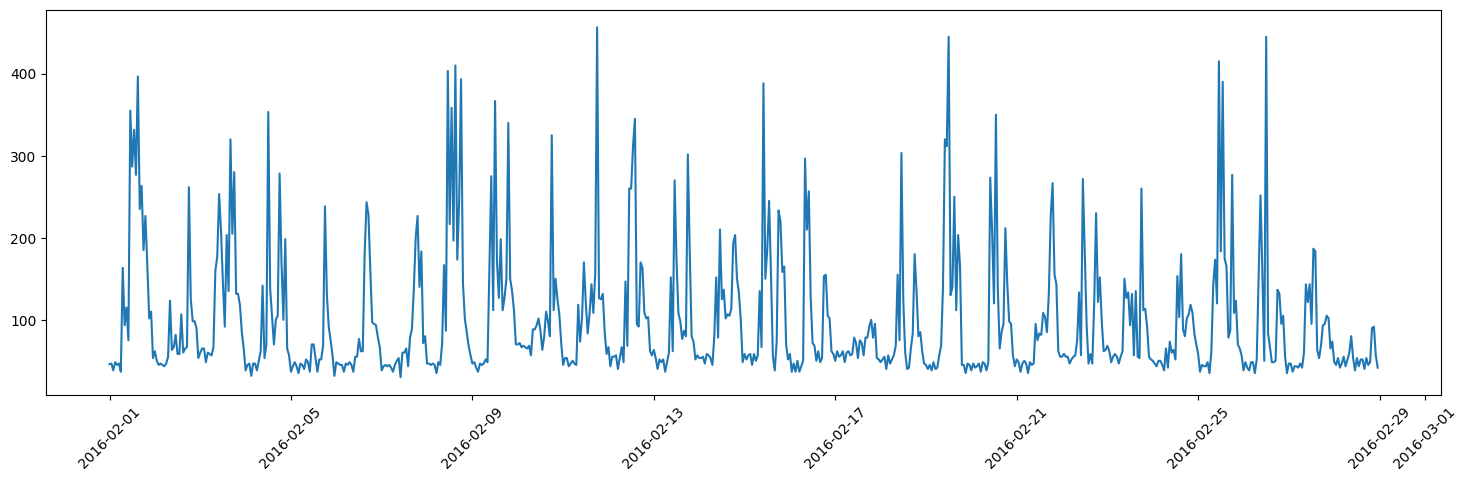

In [18]:
# 위의 그래프와 비교해서 좀 더 부드러워진 것을 확인할 수 있다.
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(data['Appliances'])
plt.xticks(rotation=45)
plt.show()

데이터 세트의 총 길이는 672. 648개의 값을 훈련 데이터로 사용.

일단 훈련되면 모델은 미래의 24개 값(24시간의 데이터)을 예측한다.

In [19]:
train_data = data.head(n=648)
test_data = data.tail(n=24)

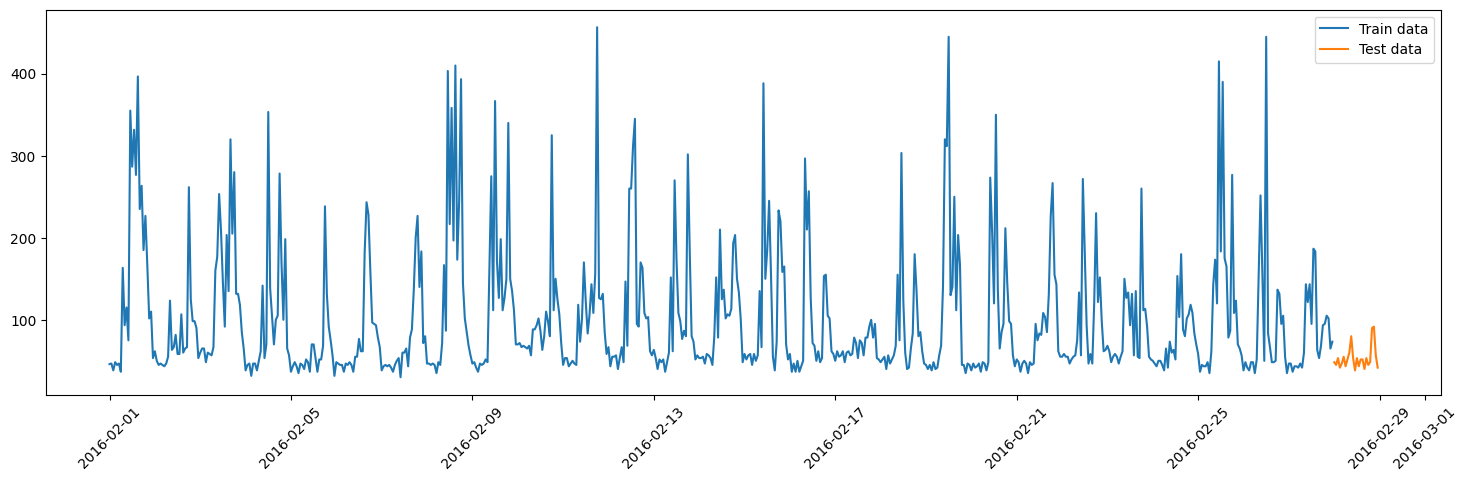

In [20]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['Appliances'], label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.xticks(rotation=45)
plt.legend()
plt.show()

그래프에서 주황색 부분이 우리가 예측하려는 부분이다.

In [21]:
# Constant variables
forecast_horizon = 24
train_size = 648

# Baseline
베이스라인은 훈련 데이터의 평균값만 예측하는 간단한 모델이다. 우선 이 모델에 대해서 평균 제곱 오차(MSE)를 계산하고 이 값보가 더 나쁜 MSE를 갖는 모델은 고려하지 않는다.

시계열이 고정되어 있지 않는 경우 이는 좋은 기준선처럼 보이지 않을 수 있다. 하지만 시계열이 고정되어있는 경우 좋은 기준선이 될 수 있다.

In [22]:
baseline_forecasts = forecast_horizon*[train_data['Appliances'].mean()]
baseline_mse = mean_squared_error(test_data['Appliances'].values, baseline_forecasts)

In [23]:
baseline_mse

2419.1014742523166

# Stationary test

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
result = adfuller(train_data['Appliances'].values)
print('ADF Statistic: %f' % result[0])

ADF Statistic: -10.044526


데이터는 거의 고정적. 음수 값이 클수록 데이터가 더 안정적임을 의미한다. 고정되지 않은 데이터 세트는 높은 ADF 통계량을 갖는다. 데이터 세트가 거의 고정되어 있으므로 작은 차분 값을 사용하여 더 고정적으로 만들 수 있다.

# Partial Auto Correlation Plot
부분 자기 상관 플롯은 데이터 포인트의 값이 이전 데이터 포인트의 값에 얼마나 의존하는지에 대한 정보를 제공한다.

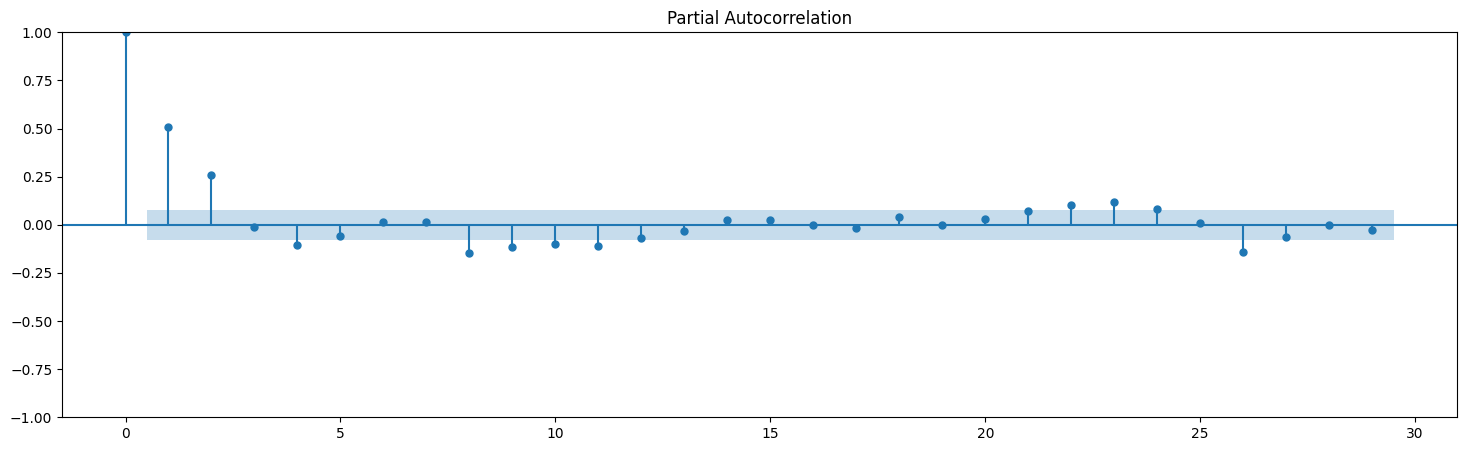

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['Appliances'])
plt.show()

위의 플롯을 보면 처음 두 값 사이에만 강한 상관 관계가 있다. 자동 회귀 모델(ARIMA, SARIMA, Auto-ARIMA)의 경우 AR 매개변수 2가 좋다. 데이터는 거의 고정되어 있으므로 1의 작은 차이가 맞을 것이다.

# Scaling Data

In [27]:
# Scaling. We will use standard scaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data['Appliances'].values.reshape(-1, 1))

# 1. ARIMA

In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
# Values for 'order' parameter are selected after hyper parameter tuning. These values give the lowest MSE of all the values
# we tried.
model = ARIMA(scaled_train_data, order=(2,1,0))
model = model.fit()

In [30]:
# Forecast values for next 24 hours
forecasts = model.predict(start=scaled_train_data.size, end=scaled_train_data.size+forecast_horizon-1, dynamic=True)
forecasts = scaler.inverse_transform(forecasts.reshape(-1, 1))

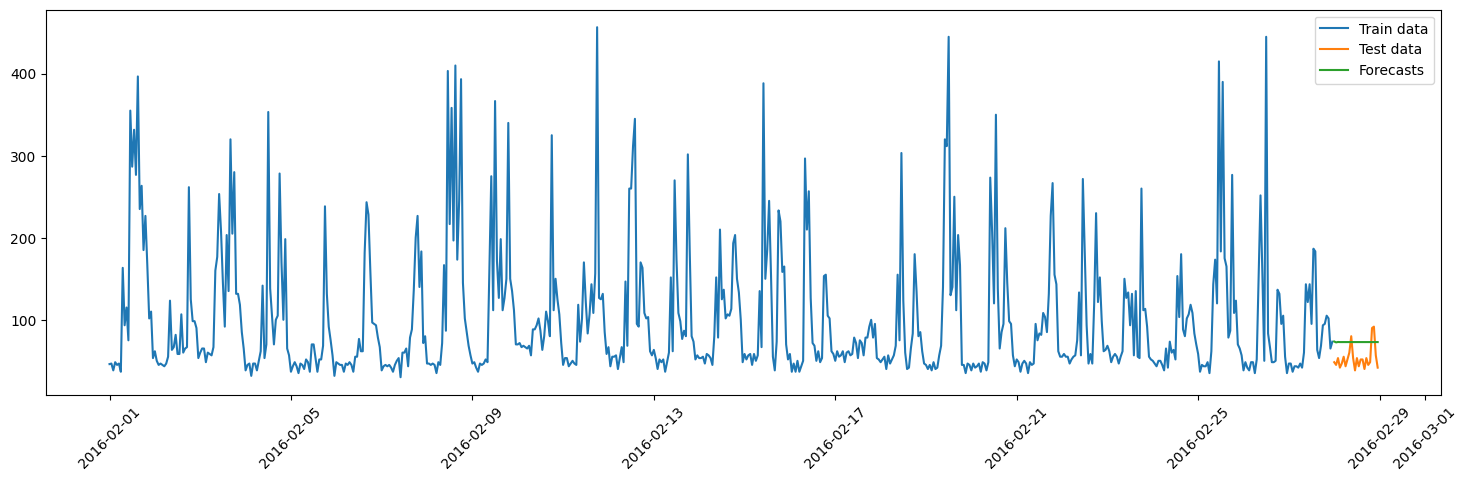

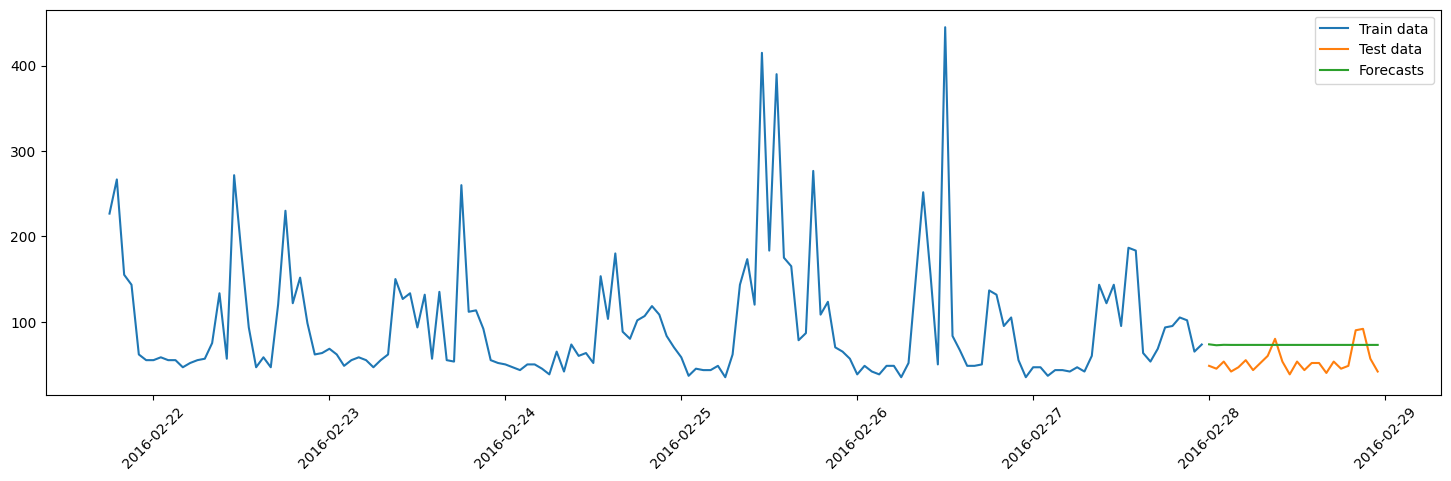

In [31]:
# Plot
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['Appliances'], label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['Appliances'].tail(150), label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [32]:
mse = mean_squared_error(test_data['Appliances'].values, forecasts)
mse

571.9625111446409

베이스라인 보다 MSE가 나쁘지 않지만, 예측 결과는 그렇게 좋아 보이지 않는다.

# 2. Prophet

In [ ]:
# !pip install fbprophet

In [33]:
from prophet import Prophet # Prophet 라이브러리 설치 필요
import pandas as pd

In [34]:
train_data.head()

,Appliances,T1,RH_1
date,,,
2016-02-01 00:00:00,46.000000,22.121667,46.613167
2016-02-01 01:00:00,46.666667,21.904444,47.050000
2016-02-01 02:00:00,38.333333,21.718889,46.966667
2016-02-01 03:00:00,48.333333,21.562500,47.011528
2016-02-01 04:00:00,45.000000,21.390556,47.122778


Prophet은 입력 데이터가 2개의 열을 포함하는 데이터 프레임이어야 한다. datetime 형식의 시간 값을 포함하는 'ds' 열과 훈련 데이터를 포함하는 'y' 열.

In [35]:
prophet_train_data = train_data.reset_index()
prophet_train_data.columns = ['ds', 'y', 'T1', 'RH_1']

prophet_train_data.head()

,ds,y,T1,RH_1
0,2016-02-01 00:00:00,46.000000,22.121667,46.613167
1,2016-02-01 01:00:00,46.666667,21.904444,47.050000
2,2016-02-01 02:00:00,38.333333,21.718889,46.966667
3,2016-02-01 03:00:00,48.333333,21.562500,47.011528
4,2016-02-01 04:00:00,45.000000,21.390556,47.122778


In [36]:
# fitting
model = Prophet()
model.fit(prophet_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcepsyv5/7mkocdwq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcepsyv5/jfn5n3ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96396', 'data', 'file=/tmp/tmptcepsyv5/7mkocdwq.json', 'init=/tmp/tmptcepsyv5/jfn5n3ra.json', 'output', 'file=/tmp/tmptcepsyv5/prophet_modelincfkyv_/prophet_model-20231030013818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
# Create a forecast dataframe containing only dates
forecast_df = test_data.reset_index()
forecast_df = forecast_df[['date']]
forecast_df.columns = ['ds']
forecast_df.head()

,ds
0,2016-02-28 00:00:00
1,2016-02-28 01:00:00
2,2016-02-28 02:00:00
3,2016-02-28 03:00:00
4,2016-02-28 04:00:00


In [38]:
# Forecast values
forecast_values = model.predict(forecast_df)
forecast_values = forecast_values[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

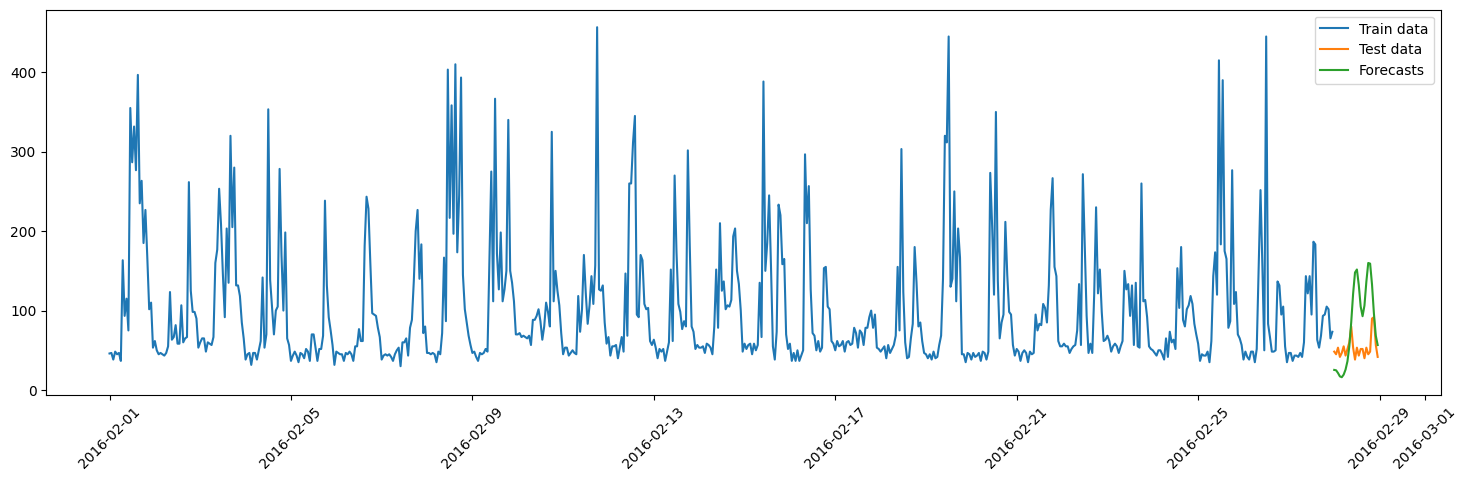

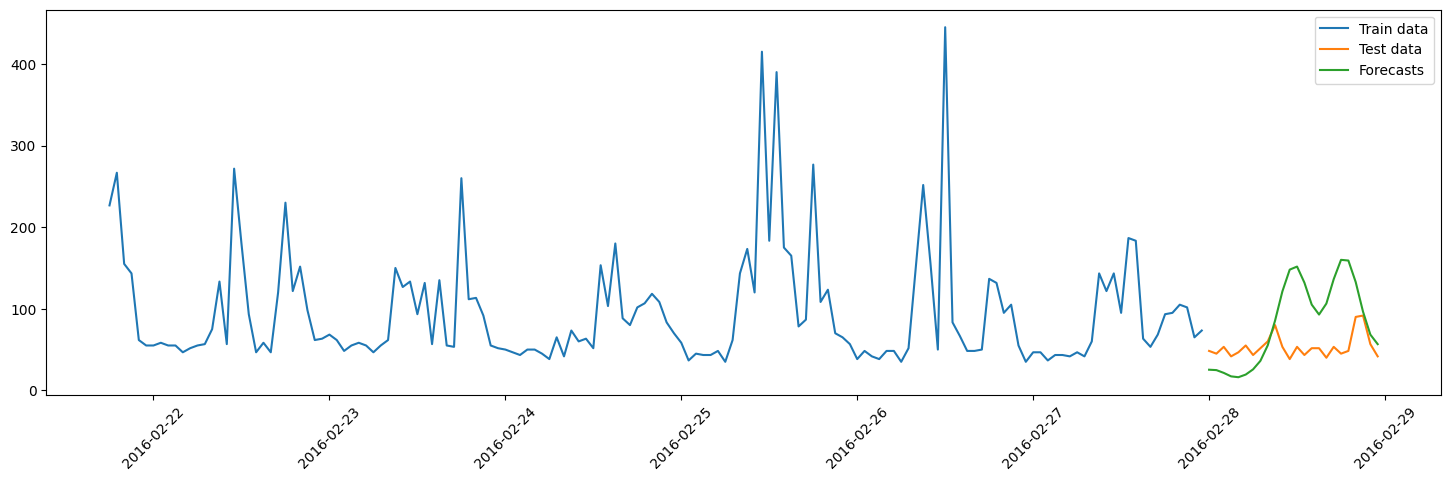

In [39]:
# Plot
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['Appliances'], label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecast_values['yhat'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['Appliances'].tail(150), label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(forecast_values['ds'], forecast_values['yhat'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [40]:
mse = mean_squared_error(test_data['Appliances'].values, forecast_values['yhat'].values)
mse

3461.4488603428867

ARIMA 결과와 달리 현재 예측에 약간의 변동이 있다. 그러나 MSE는 비교적 높다.

# 3. SARIMA

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
my_order = (2, 1, 0)
my_seasonal_order = (2, 1, 0, 5)

In [43]:
# define model & fitting
model = SARIMAX(scaled_train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit(disp=0)

In [44]:
# Forecast total vaccinations for next 90 days
forecasts = model_fit.predict(start=scaled_train_data.size, end=scaled_train_data.size+forecast_horizon-1)
forecasts = scaler.inverse_transform(forecasts.reshape(-1, 1))

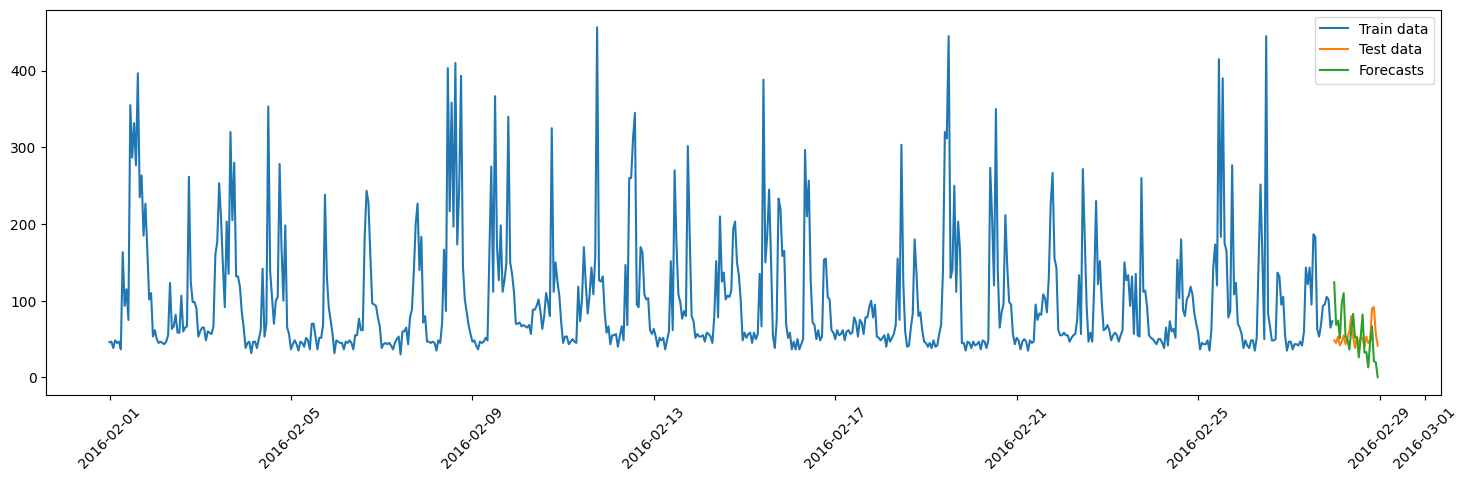

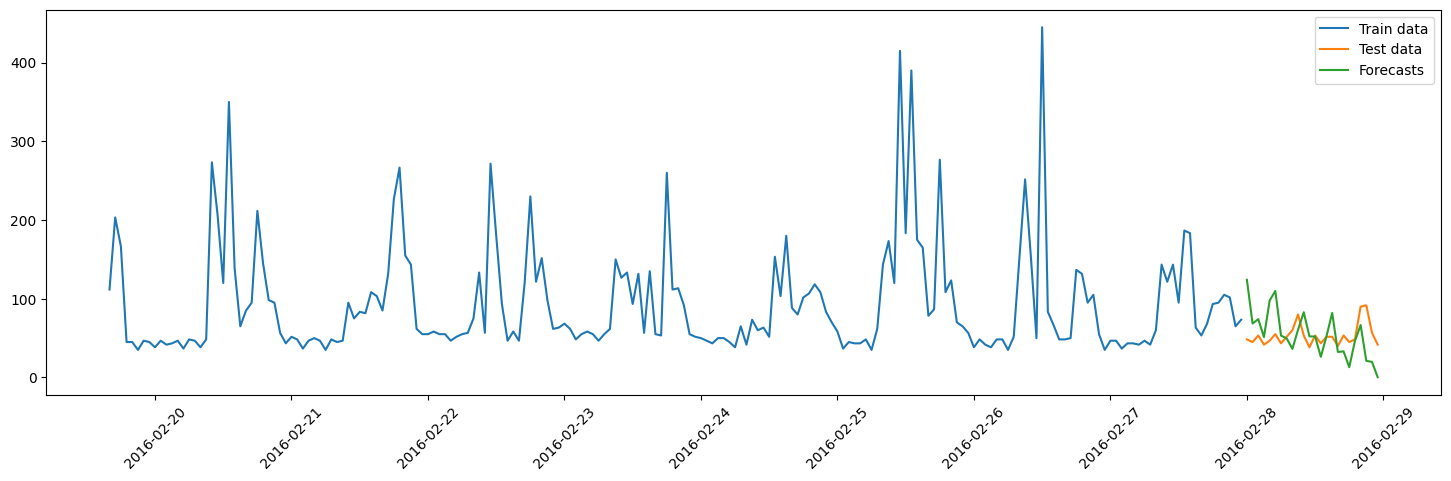

In [45]:
# Plot
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['Appliances'], label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['Appliances'].tail(200), label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [46]:
mse = mean_squared_error(test_data['Appliances'].values, forecasts)
mse

1076.5105714892613

모델이 하향 추세를 예측할 수 있다. 또한 MSE도 좋은 값을 갖는다.

# 4. Auto ARIMA

In [47]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00


In [48]:
from pmdarima.arima import auto_arima

In [49]:
arima_model = auto_arima(train_data['Appliances'].values, start_p=0, d=1, start_q=0, max_p=5, max_d=0, max_q=5,
                         start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=False, error_action='warn',
                         suppress_warnings=True, trace=True, stepwise=True, random_state=20, n_fits=50)

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7460.494, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7323.547, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7314.411, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7458.495, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7314.644, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7315.552, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7315.626, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7312.413, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7312.645, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7313.552, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7321.548, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7313.627, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.285 seconds


In [50]:
# Forecasting
forecasts = arima_model.predict(n_periods=forecast_horizon)
forecast_df = pd.DataFrame(forecasts, index=test_data.index)
forecast_df.columns = ['forecasts']
forecast_df.head()

,forecasts
date,
2016-02-28 00:00:00,77.605587
2016-02-28 01:00:00,77.605587
2016-02-28 02:00:00,77.605587
2016-02-28 03:00:00,77.605587
2016-02-28 04:00:00,77.605587


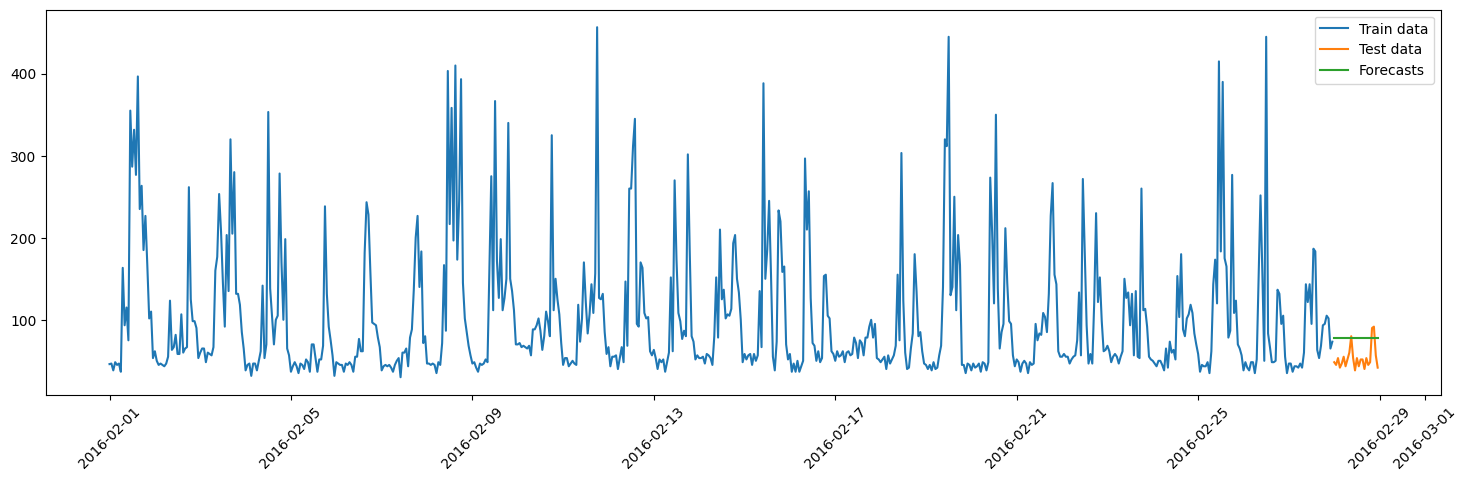

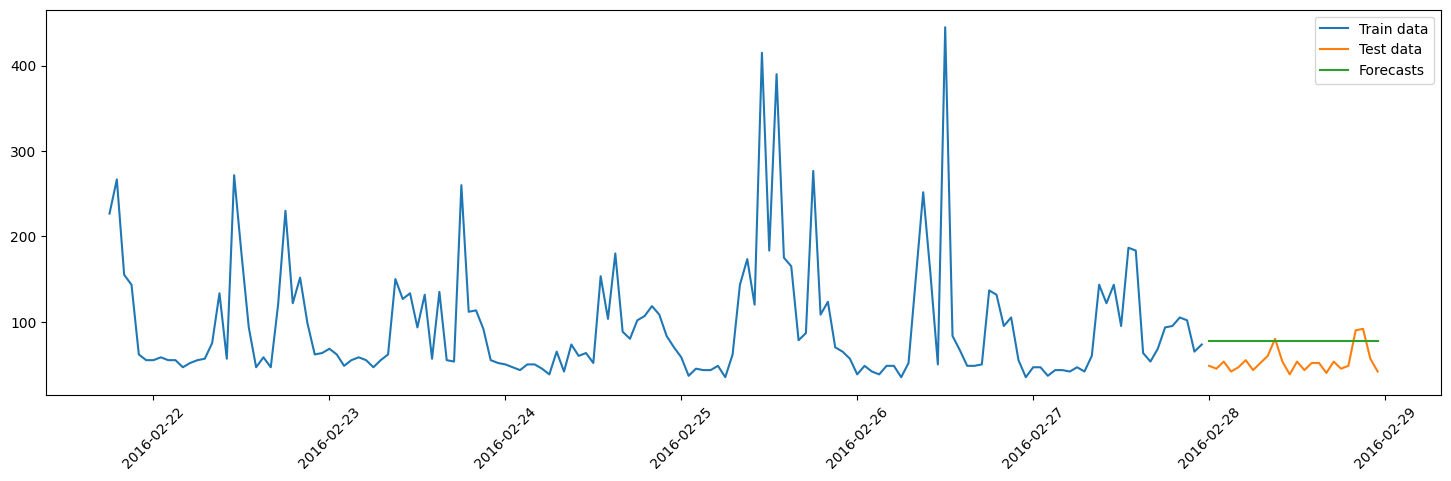

In [51]:
# Plot
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['Appliances'], label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['Appliances'].tail(150), label='Train data')
plt.plot(test_data['Appliances'], label='Test data')
plt.plot(forecast_df['forecasts'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Conclusion

1. MSE는 시계열 예측과 관련하여 모델 성능의 좋은 척도가 아니다.
2. 위의 실험과 그 결과를 바탕으로 SARIMA 알고리즘은 임의의 시계열 예측에 있어 다른 알고리즘보다 훨씬 우수하다.
3. 데이터에 명확한 추세나 계절성이 있는 경우 다른 알고리즘, 특히 prophet도 정말 좋은 결과를 제공하지만 항상 그렇지는 않을수 있고, 위에서 보여준 것과 같은 경우에서는 SARIMA가 가장 좋은 결과를 보여준다.